In [1]:
import os
import cv2

# Define the path to the extracted dataset
folder_path = r"D:\\caltech-101\\caltech-101\\101_ObjectCategories\\101_ObjectCategories"

# Function to load images using OpenCV
def load_images_opencv(folder_path):
    images = []
    labels = []
    valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.gif')  # Supported image formats

    for category in os.listdir(folder_path):
        category_path = os.path.join(folder_path, category)
        
        # Check if the path is a directory
        if os.path.isdir(category_path):
            for img_file in os.listdir(category_path):
                img_path = os.path.join(category_path, img_file)
                
                # Check if the file is an image
                if img_file.lower().endswith(valid_extensions):
                    try:
                        # Read the image using OpenCV
                        img = cv2.imread(img_path)
                        if img is not None:
                            # Convert from BGR to RGB
                            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                            images.append(img)
                            labels.append(category)  # Use the folder name as the label
                        else:
                            print(f"OpenCV failed to load image {img_path}")
                    except Exception as e:
                        print(f"Error loading image {img_path}: {e}")
                else:
                    print(f"Skipping non-image file: {img_path}")
    return images, labels

# Load the images and labels
images, labels = load_images_opencv(folder_path)

# Verify that images and labels are loaded
print(f"Total images loaded: {len(images)}")
print(f"Total labels loaded: {len(labels)}")


Skipping non-image file: D:\\caltech-101\\caltech-101\\101_ObjectCategories\\101_ObjectCategories\BACKGROUND_Google\tmp
Total images loaded: 9144
Total labels loaded: 9144


In [2]:
# Define the target image size
IMAGE_SIZE = 128

# Resize images and ensure labels match
images_resized = []
labels_resized = []

for img, label in zip(images, labels):
    try:
        # Resize the image to the target size
        resized_img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
        images_resized.append(resized_img)  # Append the resized image
        labels_resized.append(label)       # Append the corresponding label
    except Exception as e:
        print(f"Error resizing image: {e}")

# Verify resizing step
print(f"Total resized images: {len(images_resized)}")
print(f"Total resized labels: {len(labels_resized)}")

Total resized images: 9144
Total resized labels: 9144


In [3]:
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

# Ensure there are labels to encode
if len(labels_resized) == 0:
    raise ValueError("No labels found! Please check your data loading process.")

# Encode labels as integers using LabelBinarizer
label_binarizer = LabelBinarizer()
labels_encoded = label_binarizer.fit_transform(labels_resized)

# Convert labels to categorical format
NUM_CLASSES = len(label_binarizer.classes_)
labels_encoded = to_categorical(labels_encoded, num_classes=NUM_CLASSES)

# Verify encoding step
print(f"Labels encoded shape: {labels_encoded.shape}")
print(f"Number of classes: {NUM_CLASSES}")

Labels encoded shape: (9144, 102, 102)
Number of classes: 102


In [4]:
from sklearn.model_selection import train_test_split
import numpy as np

# Convert images to a numpy array for processing
images_resized = np.array(images_resized)

# Split data: 80% train, 10% validation, 10% test
X_train, X_temp, y_train, y_temp = train_test_split(
    images_resized, labels_encoded, test_size=0.2, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

# Verify the data split
print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

Training set size: 7315
Validation set size: 914
Test set size: 915


Training set performance:
Train Accuracy: 0.9861
Train Precision: 0.9862
Train Recall: 0.9861

Test set performance:
Test Accuracy: 0.9750
Test Precision: 0.9750
Test Recall: 0.9750


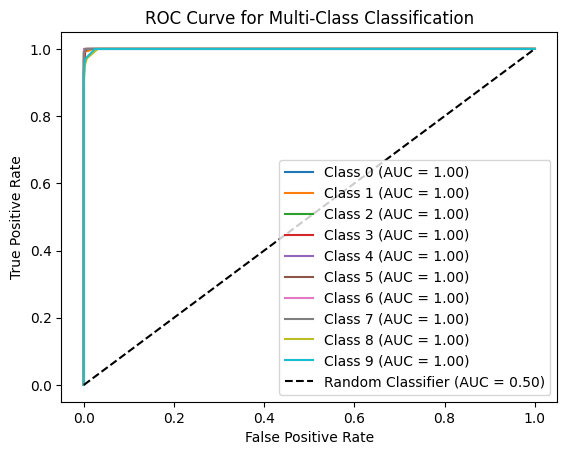


AUC Scores for each class:
Class 0: AUC = 1.0000
Class 1: AUC = 0.9999
Class 2: AUC = 1.0000
Class 3: AUC = 0.9999
Class 4: AUC = 1.0000
Class 5: AUC = 0.9999
Class 6: AUC = 1.0000
Class 7: AUC = 1.0000
Class 8: AUC = 0.9993
Class 9: AUC = 0.9995


In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_curve, auc
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import datasets

# Load dataset - using digits dataset as an example (replace with your custom dataset)
digits = datasets.load_digits()
X, y = digits.data, digits.target  # Feature data and labels

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardization (Normalize features for better performance in KNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# PCA for dimensionality reduction (optional, can improve KNN performance)
pca = PCA(n_components=50)  # Reduce to 50 components (adjust as needed)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Train a KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)  # You can adjust n_neighbors as needed
knn.fit(X_train_pca, y_train)

# Predictions
train_preds = knn.predict(X_train_pca)
test_preds = knn.predict(X_test_pca)

# Evaluate the performance (precision, recall, accuracy)
def evaluate_model(predictions, true_labels, data_type="Test"):
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average='weighted', zero_division=1)
    recall = recall_score(true_labels, predictions, average='weighted', zero_division=1)
    print(f"{data_type} Accuracy: {accuracy:.4f}")
    print(f"{data_type} Precision: {precision:.4f}")
    print(f"{data_type} Recall: {recall:.4f}")
    return accuracy, precision, recall

print("Training set performance:")
train_accuracy, train_precision, train_recall = evaluate_model(train_preds, y_train, "Train")

print("\nTest set performance:")
test_accuracy, test_precision, test_recall = evaluate_model(test_preds, y_test, "Test")

# ROC Curve (One-vs-Rest approach for multi-class classification)
y_train_bin = label_binarize(y_train, classes=np.unique(y_train))
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

# Get the predicted probabilities for each class
train_probs = knn.predict_proba(X_train_pca)
test_probs = knn.predict_proba(X_test_pca)

# Compute ROC curve for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(y_train_bin.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_train_bin[:, i], train_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves
plt.figure()
for i in range(y_train_bin.shape[1]):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.50)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc='lower right')
plt.show()

# Print final AUC scores
print("\nAUC Scores for each class:")
for i in range(len(roc_auc)):
    print(f"Class {i}: AUC = {roc_auc[i]:.4f}")


C:\Users\pacha\anaconda3\envs\mytfenv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVM Test Accuracy: 0.1000
SVM Test Precision: 0.0253
SVM Test Recall: 0.1000


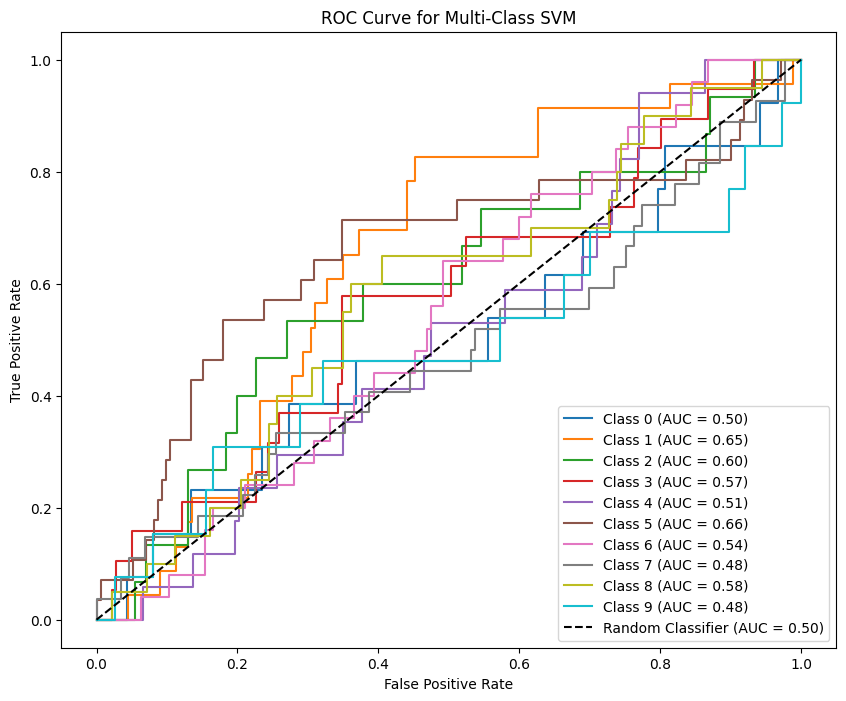


AUC Scores for each class:
Class 0: AUC = 0.4977
Class 1: AUC = 0.6505
Class 2: AUC = 0.5957
Class 3: AUC = 0.5670
Class 4: AUC = 0.5069
Class 5: AUC = 0.6553
Class 6: AUC = 0.5426
Class 7: AUC = 0.4774
Class 8: AUC = 0.5758
Class 9: AUC = 0.4796


In [10]:
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Dummy data (replace with your actual data)
X = np.random.randn(1000, 32, 32, 3)  # 1000 samples of 32x32 RGB images
y = np.random.randint(0, 10, 1000)    # Labels (10 classes)

# Split data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Flatten the data
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Train the SVM model
svm = SVC(kernel='rbf', probability=True, random_state=42)
svm.fit(X_train_flat, y_train)

# Predictions
y_test_pred_svm = svm.predict(X_test_flat)

# Test evaluation
accuracy_test_svm = accuracy_score(y_test, y_test_pred_svm)
precision_test_svm = precision_score(y_test, y_test_pred_svm, average='weighted')
recall_test_svm = recall_score(y_test, y_test_pred_svm, average='weighted')

print(f"SVM Test Accuracy: {accuracy_test_svm:.4f}")
print(f"SVM Test Precision: {precision_test_svm:.4f}")
print(f"SVM Test Recall: {recall_test_svm:.4f}")

# ROC Curve and AUC
y_test_bin = label_binarize(y_test, classes=np.unique(y))
y_test_prob_svm = svm.predict_proba(X_test_flat)

fpr, tpr, roc_auc = {}, {}, {}
for i in range(y_test_bin.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_prob_svm[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(y_test_bin.shape[1]):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.50)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class SVM')
plt.legend(loc='lower right')
plt.show()

print("\nAUC Scores for each class:")
for i in range(len(roc_auc)):
    print(f"Class {i}: AUC = {roc_auc[i]:.4f}")

In [13]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

IMAGE_SIZE = 128
NUM_CLASSES = 10  # Set the number of output classes

# Load the VGG16 model with pre-trained weights and exclude the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# Add custom classification layers
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(NUM_CLASSES, activation='softmax')(x)

# Create the full model
cnn_model = Model(inputs=base_model.input, outputs=x)

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False  # Correct indentation here

# Resize the images (to 128x128)
def resize_images(X):
    return tf.image.resize(X, (IMAGE_SIZE, IMAGE_SIZE))

# Resize the training, validation, and test images
X_train_resized = resize_images(X_train)
X_val_resized = resize_images(X_val)
X_test_resized = resize_images(X_test)

# One-hot encode the labels
y_train_one_hot = to_categorical(y_train, NUM_CLASSES)
y_val_one_hot = to_categorical(y_val, NUM_CLASSES)
y_test_one_hot = to_categorical(y_test, NUM_CLASSES)

# Compile the CNN model
cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the CNN model
history = cnn_model.fit(X_train_resized, y_train_one_hot, validation_data=(X_val_resized, y_val_one_hot), epochs=10, batch_size=32)

# Evaluate the CNN model on the validation and test sets
cnn_val_loss, cnn_val_accuracy = cnn_model.evaluate(X_val_resized, y_val_one_hot)
cnn_test_loss, cnn_test_accuracy = cnn_model.evaluate(X_test_resized, y_test_one_hot)

print(f"CNN Validation Accuracy: {cnn_val_accuracy:.4f}")


Epoch 1/10
20/20 [==============================] - 34s 2s/step - loss: 3.2040 - accuracy: 0.1125 - val_loss: 2.4362 - val_accuracy: 0.1125
Epoch 2/10
20/20 [==============================] - 37s 2s/step - loss: 2.3425 - accuracy: 0.1219 - val_loss: 2.3279 - val_accuracy: 0.0938
Epoch 3/10
20/20 [==============================] - 41s 2s/step - loss: 2.2829 - accuracy: 0.1453 - val_loss: 2.3110 - val_accuracy: 0.0875
Epoch 4/10
20/20 [==============================] - 44s 2s/step - loss: 2.2515 - accuracy: 0.1516 - val_loss: 2.3072 - val_accuracy: 0.0562
Epoch 5/10
20/20 [==============================] - 42s 2s/step - loss: 2.2577 - accuracy: 0.1609 - val_loss: 2.3365 - val_accuracy: 0.1000
Epoch 6/10
20/20 [==============================] - 43s 2s/step - loss: 2.2435 - accuracy: 0.1516 - val_loss: 2.3191 - val_accuracy: 0.1063
Epoch 7/10
20/20 [==============================] - 44s 2s/step - loss: 2.2346 - accuracy: 0.1641 - val_loss: 2.3238 - val_accuracy: 0.1000
Epoch 8/10
20/20 [==

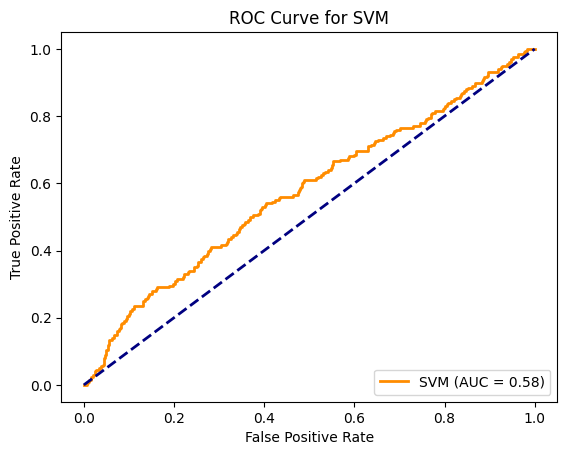

Resized X_test shape: (200, 128, 128, 3)
7/7 [==============================] - 8s 1s/step


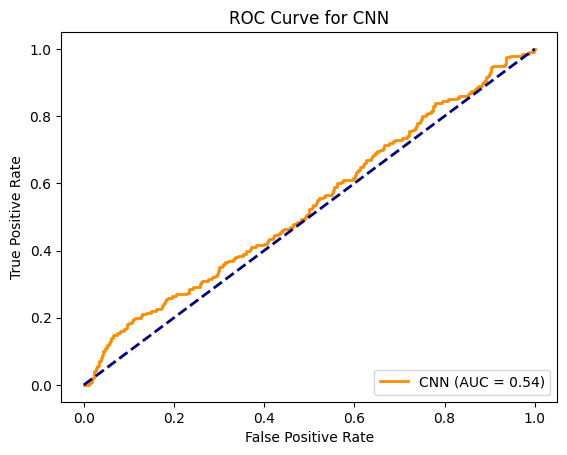

In [14]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Assuming NUM_CLASSES is defined (the number of classes in your classification problem)
NUM_CLASSES = 10  # Example, set this according to your specific problem

# Binarize the labels for ROC curve calculations
y_test_binarized = label_binarize(y_test, classes=range(NUM_CLASSES))

# Helper function to plot ROC curve for a model
def plot_roc_curve(y_true, y_pred_proba, model_name):
    fpr, tpr, _ = roc_curve(y_true.ravel(), y_pred_proba.ravel())
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend(loc='lower right')
    plt.show()

# ROC for SVM (using predict_proba)
y_test_pred_proba_svm = svm.predict_proba(X_test_flat)  # SVM gives probabilities with predict_proba
plot_roc_curve(y_test_binarized, y_test_pred_proba_svm, "SVM")

# Resize X_test to the expected input shape for the CNN model (128, 128, 3)
X_test_resized = tf.image.resize(X_test, (128, 128))

# Ensure the resized images have the right shape for the model
print(f"Resized X_test shape: {X_test_resized.shape}")

# ROC for CNN (using predict_proba)
y_test_pred_proba_cnn = cnn_model.predict(X_test_resized)  # CNN model should also give probabilities
plot_roc_curve(y_test_binarized, y_test_pred_proba_cnn, "CNN")